In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# PROJECT | NATURAL LANGUAGE PROCESSING CHALLENGE

## INTRODUCTION

##### Learning how to process text is a skill required for Data Scientists/AI Engineers.

##### In this project, you will put these skills into practice to identify whether a news headline is real or fake news.

## PROJECT OVERVIEW

##### In the file dataset/data.csv, you will find a dataset containing news articles with the following columns:

##### Once you have a classifier built, then use it to predict the labels for dataset/validation_data.csv. Generate a new file where the label 2 has been replaced by 0 (fake) or 1 (real) according to your model. Please respect the original file format, do not include extra columns, and respect the column separator.

##### Please ensure to split the data.csv into training and test datasets before using it for model training or evaluation.

##### Your goal is to build a classifier that is able to distinguish between the two.

##### Text Preprocessing: Cleaning and preparing the data using tokenization, stopword removal, and lemmatization.

##### Feature Extraction: Converting text into numerical vectors using both CountVectorizer and TF-IDF Vectorizer.

##### Model Development: Implemented and evaluated three different approaches:

##### countVectorizer + Multinimial Naive Bayes, countVectorizer + Random Forest, TF-IDF + Random Forest, TF-IDF + Naive Bayes

##### Model Evaluation: Compared all models using accuracy, confusion matrix, and F1-score to determine the most effective approach

### Text Classification Pipeline with Multiple Models

#### STEP 1 : IMPORT LIBRARIES

##### Explanation:
We import libraries for data handling, text preprocessing, feature extraction, machine learning, evaluation, and visualization.

In [2]:
# Data handling
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package punkt to /Users/dhana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dhana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dhana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### STEP 2 : LOAD DATASET

##### Explanation:
This loads the dataset, renames columns, and prints a preview.

In [3]:
# Load training data
df = pd.read_csv("~/Library/Mobile Documents/com~apple~CloudDocs/Ironhack/Project_2/training_data_lowercase.csv", sep="\t", header=None, names=['label','title'], encoding='utf-8', engine='python')

# Display shape and head
print(df.shape)
print(df.head())


(34152, 2)
   label                                              title
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...


#### STEP 3 : TEXT PREPROCESSING

##### Explanation:
This function tokenizes, removes stopwords, applies lemmatization and stemming, and cleans text. We apply it to the entire dataset.

The preprocessing function prepares raw text data for machine learning by performing several key steps:

##### Tokenization:  Splits the text into individual words (tokens) so each word can be analyzed separately.

##### Stopword Removal: Removes common words like “the”, “is”, “and” that don’t carry meaningful information for classification.

##### Cleaning:  Eliminates punctuation, numbers, and other non-letter characters to reduce noise.

##### Lemmatization: Converts words to their base or dictionary form (e.g., “running” → “run”) to treat similar words the same.

##### Stemming:  Reduces words to their root form (e.g., “played” → “play”), further simplifying the vocabulary.

In [4]:
def preprocess_text(text):
    # --- Clean hidden or unwanted characters ---
    if not isinstance(text, str):
        text = str(text)
    text = text.replace('\ufeff', '')        # Remove BOM characters
    text = text.strip()                      # Remove leading/trailing spaces
    text = re.sub(r'\s+', ' ', text)         # Normalize multiple spaces
    
    # --- Tokenization ---
    tokens = word_tokenize(text.lower())
    
    # --- Remove stopwords ---
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    
    # --- Remove punctuation and numbers ---
    tokens = [re.sub(r'[^a-zA-Z]', '', t) for t in tokens]
    tokens = [t for t in tokens if t]  # Remove empty strings
    
    # --- Lemmatization ---
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    # --- Stemming ---
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(t) for t in tokens]
    
    return ' '.join(tokens)

In [5]:
# Apply preprocessing
df['Processed_Text'] = df['title'].apply(preprocess_text)

#### STEP 4 : SPLIT DATA 

##### Explanation:
Split the data into training and validation sets.


In [6]:
X = df['Processed_Text']
y = df['label'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#### STEP 5 : FEATURE EXTRACTION

##### Explanation:
We prepare two types of features: Bag-of-Words (CountVectorizer) and TF-IDF.

In [7]:
# CountVectorizer for Base Model
count_vect = CountVectorizer(min_df=5, ngram_range=(1,2))
X_train_count = count_vect.fit_transform(X_train)
X_val_count  = count_vect.transform(X_val)
print("CountVectorizer shape:", X_train_count.shape)

CountVectorizer shape: (27321, 8747)


In [8]:
# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(min_df=5, ngram_range=(1,2))
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_val_tfidf  = tfidf_vect.transform(X_val)
print("TF-IDF shape:", X_train_tfidf.shape)

TF-IDF shape: (27321, 8747)


In [9]:
# Get total word counts from CountVectorizer
word_freq = np.asarray(X_train_count.sum(axis=0)).flatten()
words = count_vect.get_feature_names_out()

# Create a DataFrame with words and their frequencies
word_freq_df = pd.DataFrame({'Word': words, 'Frequency': word_freq})

# Sort by frequency (highest first)
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Show top 20 most frequent words
print(word_freq_df.head(20))

            Word  Frequency
7634       trump       9816
8305       video       4444
6358         say       2445
4954       obama       1933
3356        hous       1505
5989  republican       1418
6569       senat       1251
3259     hillari       1229
1272     clinton       1160
8521       white       1118
5564      presid       1058
4797         new       1012
1837    democrat        903
645         bill        891
967         call        830
8524  white hous        830
6247      russia        796
7020       state        769
2851         get        750
8356        vote        718


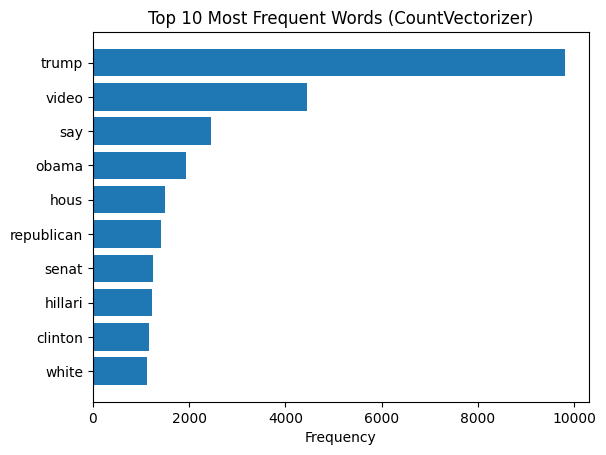

In [10]:
import numpy as np
import matplotlib.pyplot as plt

word_freq = np.asarray(X_train_count.sum(axis=0)).flatten()
words = count_vect.get_feature_names_out()

top_indices = word_freq.argsort()[-10:][::-1]
top_words = [words[i] for i in top_indices]
top_freq = word_freq[top_indices]

plt.barh(top_words[::-1], top_freq[::-1])
plt.title("Top 10 Most Frequent Words (CountVectorizer)")
plt.xlabel("Frequency")
plt.show()


### BASE MODEL: Count vectore +multinomial

#### COUNTVECTORIZER IMPLEMENTATION LIKE A SIMPLE BAG-OF-WORDS WITH MULTINOMIALNB

In [11]:
# Implement Bag of Words
countvector_m1 = CountVectorizer(ngram_range=(1,2), min_df=5)
X_train_count_m1 = countvector_m1.fit_transform(X_train)
X_val_count_m1  = countvector_m1.transform(X_val)

# Train Naive Bayes on Count Vectors
nb_count_m1 = MultinomialNB()
nb_count_m1.fit(X_train_count_m1, y_train)

# Predict and evaluate
pred_nb_t_count_m1 = nb_count_m1.predict(X_train_count_m1)
print("Train accuracy:", accuracy_score(y_train, pred_nb_t_count_m1))

pred_nb_v_count_m1 = nb_count_m1.predict(X_val_count_m1)
print("Validation accuracy:", accuracy_score(y_val, pred_nb_v_count_m1))


Train accuracy: 0.9418762124373192
Validation accuracy: 0.9298784950958864


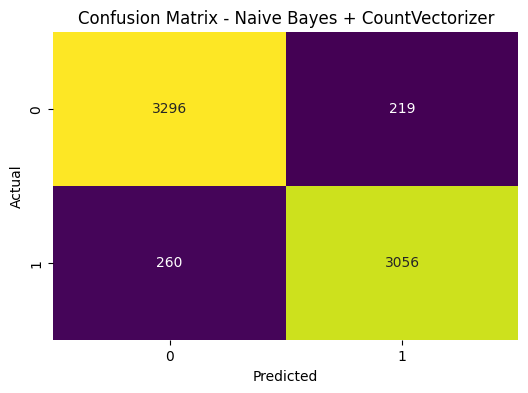

              precision    recall  f1-score      support
0              0.926884  0.937696  0.932259  3515.000000
1              0.933130  0.921592  0.927325  3316.000000
accuracy       0.929878  0.929878  0.929878     0.929878
macro avg      0.930007  0.929644  0.929792  6831.000000
weighted avg   0.929916  0.929878  0.929864  6831.000000


/var/folders/43/w059gz5x76g94491sqt2f0kh0000gn/T/ipykernel_3781/3362180651.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df_m1.index[:-3], y=report_df_m1['f1-score'][:-3], palette='viridis')


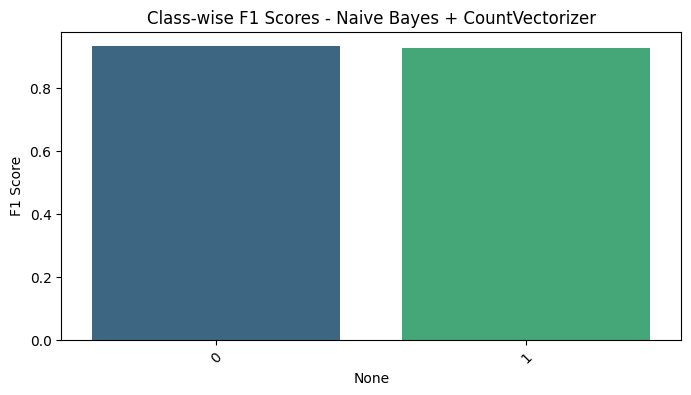

In [12]:
# ---- Confusion Matrix Heatmap ----
cm_m1 = confusion_matrix(y_val, pred_nb_v_count_m1)
plt.figure(figsize=(6,4))
sns.heatmap(cm_m1, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.title(f"Confusion Matrix - Naive Bayes + CountVectorizer")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ---- Class-wise F1 Score Bar Plot ----
report_m1 = classification_report(y_val, pred_nb_v_count_m1, output_dict=True)
report_df_m1 = pd.DataFrame(report_m1).transpose()
print(report_df_m1)

plt.figure(figsize=(8,4))
sns.barplot(x=report_df_m1.index[:-3], y=report_df_m1['f1-score'][:-3], palette='viridis')
plt.title('Class-wise F1 Scores - Naive Bayes + CountVectorizer')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()





### Model 2: Count Vector + Random Forest

CountVectorizer shape rf: (27321, 8747)
Random Forest + CountVectorizer Train accuracy: 1.0
Random Forest + CountVectorizer Validation accuracy: 0.9177

Classification Report:
              precision    recall  f1-score      support
0              0.913007  0.928592  0.920733  3515.000000
1              0.922912  0.906212  0.914486  3316.000000
accuracy       0.917728  0.917728  0.917728     0.917728
macro avg      0.917959  0.917402  0.917610  6831.000000
weighted avg   0.917815  0.917728  0.917701  6831.000000


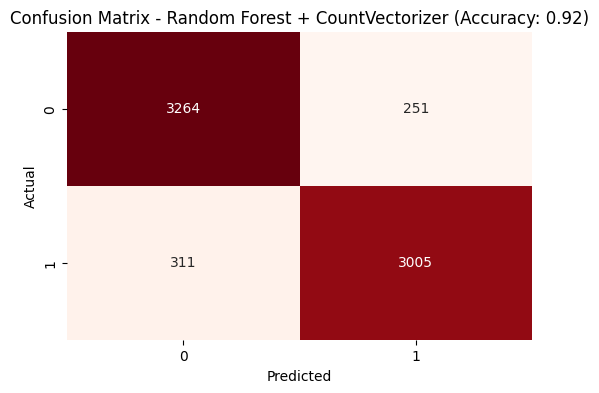

/var/folders/43/w059gz5x76g94491sqt2f0kh0000gn/T/ipykernel_3781/1757053903.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df_m2.index[:-3], y=report_df_m2['f1-score'][:-3], palette='rocket')


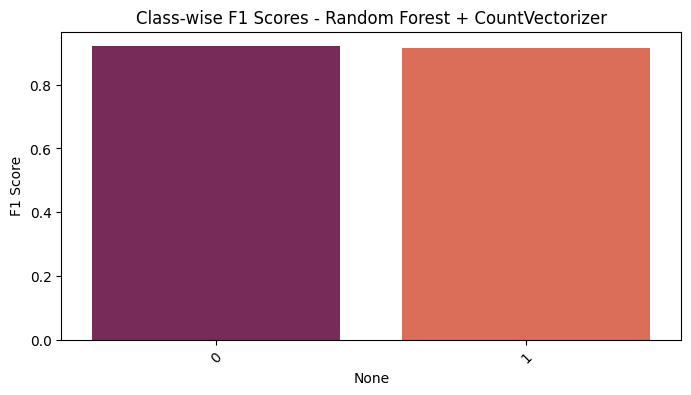

In [13]:

count_vect_rf_m2 = CountVectorizer(min_df=5, ngram_range=(1,2))
X_train_count_rf_m2 = count_vect_rf_m2.fit_transform(X_train)
X_val_count_rf_m2  = count_vect_rf_m2.transform(X_val)
print("CountVectorizer shape rf:", X_train_count_rf_m2.shape)

# ---- Train Random Forest on Count Vectors ----
rf_count_cv_m2 = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=42)
rf_count_cv_m2.fit(X_train_count_rf_m2, y_train)

# ---- Predict ----
pred_rf_t_count_m2 = rf_count_cv_m2.predict(X_train_count_rf_m2)
pred_rf_v_count_m2 = rf_count_cv_m2.predict(X_val_count_rf_m2)

# ---- Accuracy ----
rfcv_t_accuracy_m2 = accuracy_score(y_train, pred_rf_t_count_m2)
print("Random Forest + CountVectorizer Train accuracy:", round(rfcv_t_accuracy_m2, 4))
rfcv_v_accuracy_m2 = accuracy_score(y_val, pred_rf_v_count_m2)
print("Random Forest + CountVectorizer Validation accuracy:", round(rfcv_v_accuracy_m2, 4))

# ---- Classification Report Table ----
report_m2 = classification_report(y_val, pred_rf_v_count_m2, output_dict=True)
report_df_m2 = pd.DataFrame(report_m2).transpose()
print("\nClassification Report:")
print(report_df_m2)

# ---- Confusion Matrix Heatmap ----
cm_m2 = confusion_matrix(y_val, pred_rf_v_count_m2)
plt.figure(figsize=(6,4))
sns.heatmap(cm_m2, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title(f'Confusion Matrix - Random Forest + CountVectorizer (Accuracy: {rfcv_v_accuracy_m2:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ---- Class-wise F1 Score Bar Plot ----
plt.figure(figsize=(8,4))
sns.barplot(x=report_df_m2.index[:-3], y=report_df_m2['f1-score'][:-3], palette='rocket')
plt.title('Class-wise F1 Scores - Random Forest + CountVectorizer')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()


### MODEL 3: TF-IDF + Random Forest

##### TRAIN RANDOM FOREST ON TF-IDF VECTOR (TF-IDF + RANDOM FOREST)

In [14]:
# TF-IDF Vectorizer
tfidf_vect_m3 = TfidfVectorizer(min_df=5, ngram_range=(1,2))
X_train_tfidf_m3 = tfidf_vect_m3.fit_transform(X_train)
X_val_tfidf_m3  = tfidf_vect_m3.transform(X_val)


# Train Random Forest on TF-IDF vectors
randomclassifier_m3 = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=42)
randomclassifier_m3.fit(X_train_tfidf_m3, y_train)

# Predict on test TF-IDF data
train_predictions_m3 = randomclassifier_m3.predict(X_train_tfidf_m3)
val_predictions_m3 = randomclassifier_m3.predict(X_val_tfidf_m3)

# Evaluate performance
matrix_m3 = confusion_matrix(y_val, val_predictions_m3)
print(matrix_m3)

train_score_m3 = accuracy_score(y_train, train_predictions_m3)
print("Train accuracy:", train_score_m3)
val_score_m3 = accuracy_score(y_val, val_predictions_m3)
print("Validation accuracy:", val_score_m3)

report_m3 = classification_report(y_val, val_predictions_m3)
print(report_m3)

[[3244  271]
 [ 265 3051]]
Train accuracy: 1.0
Validation accuracy: 0.9215341824037476
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3515
           1       0.92      0.92      0.92      3316

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831




Confusion Matrix:
[[3244  271]
 [ 265 3051]]


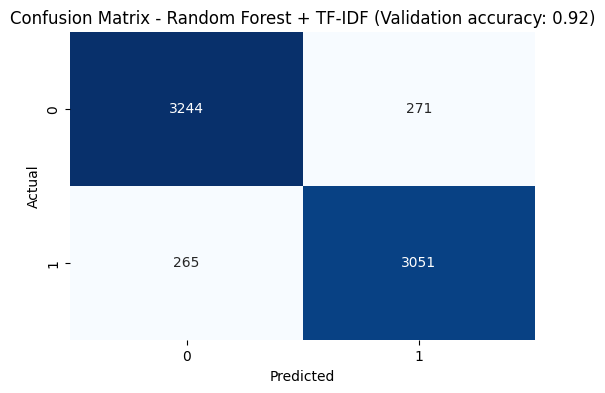

In [15]:
# Confusion matrix
cm_m3 = confusion_matrix(y_val, val_predictions_m3)
print("\nConfusion Matrix:")
print(cm_m3)

# ---- Plot Confusion Matrix ----
plt.figure(figsize=(6,4))
sns.heatmap(cm_m3, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - Random Forest + TF-IDF (Validation accuracy: {val_score_m3:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



#### MODEL4:  TF-IDF + NAIVE BAYES

Model (Naive Bayes + TF-IDF) Train accuracy: 0.9418396105559825
Model (Naive Bayes + TF-IDF) Validation accuracy: 0.9307568438003221

Classification Report:
              precision    recall  f1-score      support
0              0.926768  0.939687  0.933183  3515.000000
1              0.935109  0.921291  0.928148  3316.000000
accuracy       0.930757  0.930757  0.930757     0.930757
macro avg      0.930938  0.930489  0.930665  6831.000000
weighted avg   0.930817  0.930757  0.930739  6831.000000

Confusion Matrix:
[[3303  212]
 [ 261 3055]]


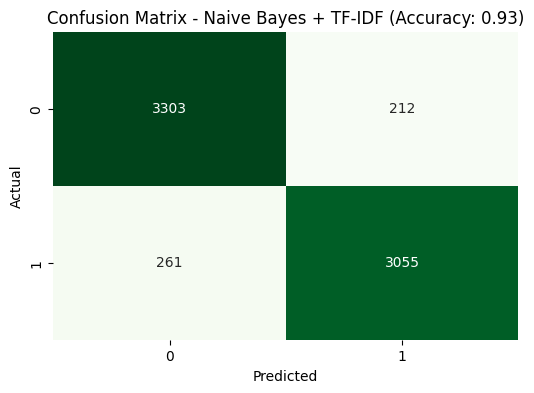

/var/folders/43/w059gz5x76g94491sqt2f0kh0000gn/T/ipykernel_3781/2898911977.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=report_df_m4.index[:-3], y=report_df_m4['f1-score'][:-3], palette='crest')


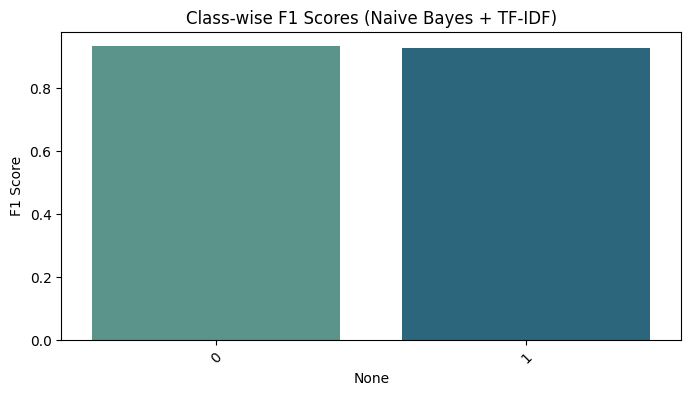

In [16]:
# TF-IDF Vectorizer
tfidf_vect_m4 = TfidfVectorizer(min_df=5, ngram_range=(1,2))
X_train_tfidf_m4 = tfidf_vect_m4.fit_transform(X_train)
X_val_tfidf_m4  = tfidf_vect_m4.transform(X_val)


# Model - Naive Bayes + TF-IDF
nb_tfidf_m4 = MultinomialNB()
nb_tfidf_m4.fit(X_train_tfidf_m4, y_train)
pred_v_tfidf_m4 = nb_tfidf_m4.predict(X_val_tfidf_m4)
pred_t_tfidf_m4 = nb_tfidf_m4.predict(X_train_tfidf_m4)


train_acc_tfidfnb_m4 = accuracy_score(y_train, pred_t_tfidf_m4)
val_acc_tfidfnb_m4 = accuracy_score(y_val, pred_v_tfidf_m4)

print("Model (Naive Bayes + TF-IDF) Train accuracy:", train_acc_tfidfnb_m4)
print("Model (Naive Bayes + TF-IDF) Validation accuracy:", val_acc_tfidfnb_m4)



# ---- Classification Report ----
report_m4 = classification_report(y_val, pred_v_tfidf_m4, output_dict=True)
report_df_m4 = pd.DataFrame(report_m4).transpose()
print("\nClassification Report:")
print(report_df_m4)

# ---- Confusion Matrix ----
cm_m4 = confusion_matrix(y_val, pred_v_tfidf_m4)
print("\nConfusion Matrix:")
print(cm_m4)

# ---- Plot Confusion Matrix ----
plt.figure(figsize=(6,4))
sns.heatmap(cm_m4, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title(f'Confusion Matrix - Naive Bayes + TF-IDF (Accuracy: {val_acc_tfidfnb_m4:.2f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ---- Plot Class-wise F1 Scores ----
plt.figure(figsize=(8,4))
sns.barplot(x=report_df_m4.index[:-3], y=report_df_m4['f1-score'][:-3], palette='crest')
plt.title('Class-wise F1 Scores (Naive Bayes + TF-IDF)')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()


##### STEP 6 : PREDICT ON NEW TEST DATA

In [17]:
# Load test data
test_df = pd.read_csv("~/Library/Mobile Documents/com~apple~CloudDocs/Ironhack/Project_2/testing_data_lowercase_nolabels.csv", sep="\t", header=None, names=['label','title'], encoding='utf-8', engine='python')

In [18]:
# Adding headers 
test_df['Processed_Text'] = test_df['title'].apply(preprocess_text)

In [19]:
#Splitting of the data
X_test = test_df['Processed_Text']

# TF-IDF Vectorizer
X_test_tfidf  = tfidf_vect_m4.transform(X_test)

# Model - Naive Bayes + TF-IDF
pred_test_tfidf = nb_tfidf_m4.predict(X_test_tfidf)
test_df = test_df.drop("label", axis=1)
test_df["Predictedlabel"] = pred_test_tfidf


In [20]:
# Save predictions
output_file = "~/Downloads/testing_predictions.csv"
test_df.to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")

Predictions saved to ~/Downloads/testing_predictions.csv
